# Experiment: Human Action Recognition using VGGNet
Lucas Henrique Bahr Yau

Code for my Capstone Project at IME-USP. \\
This notebook is an adaptation from [Meet Nagadia](https://www.kaggle.com/code/meetnagadia/har-vgg/notebook)'s work on Kaggle, for the [Data Sprint 76](https://aiplanet.com/challenges/data-sprint-76-human-activity-recognition/233/overview/about) challenge.

In [ ]:
# GPU used for training
!nvidia-smi

Thu Jan 19 06:27:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |   9144MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries and classes definitions

In [ ]:
# File handling
import os
import glob

# Data processing
from random import randint
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.image as img

# Neural network libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense

# Plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Action classes
classes = {
        "calling":            0,
        "clapping":           1,
        "cycling":            2,
        "dancing":            3,
        "drinking":           4,
        "eating":             5,
        "fighting":           6,
        "hugging":            7,
        "laughing":           8,
        "listening_to_music": 9,
        "running":            10,
        "sitting":            11,
        "sleeping":           12,
        "texting":            13,
        "using_laptop":       14
}

# List of only classes, without numbering
actions = list(classes)
display(actions)

# Experiment variables
input_shape = (224,224,3)
input_size  = (input_shape[0], input_shape[1])
pooling     = "avg"
epochs      = 40

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

# Dataset handling

In [ ]:
# Downloading dataset
!wget https://www.linux.ime.usp.br/~rukasu/mac0499/Datasets.zip
print("Unzipping...\n")
!unzip -qq Datasets.zip
print("Done")

# Dataset path for Colab
path_files = "Datasets/"

--2023-01-19 05:22:53--  https://www.linux.ime.usp.br/~rukasu/mac0499/Datasets.zip
Resolving www.linux.ime.usp.br (www.linux.ime.usp.br)... 143.107.45.30
Connecting to www.linux.ime.usp.br (www.linux.ime.usp.br)|143.107.45.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 310467960 (296M) [application/zip]
Saving to: ‘Datasets.zip’

Datasets.zip        100%[===================>] 296.08M  20.1MB/s    in 18s     

2023-01-19 05:23:12 (16.6 MB/s) - ‘Datasets.zip’ saved [310467960/310467960]

Unzipping...

Done


## File loading

In [ ]:
# csv to DataFrame
train_csv = pd.read_csv(path_files + "train.csv")
test_csv = pd.read_csv(path_files + "test.csv")

# Train dataset sorting. Labels are sorted too
train_csv.sort_values(by=["label"], inplace=True)

# Get labels as list
labels_test = list(test_csv.columns)[1:]

In [ ]:
# Load images paths
train_fol = sorted(glob.glob(path_files + "train/*"))
test_fol = sorted(glob.glob(path_files + "test/*"))

In [ ]:
# Label processing
train_names = train_csv["img_name"]
train_labels = train_csv["label"]

test_names = test_csv["img_name"]
test_labels = test_csv.values[:, 1:].tolist() # only categories (labels)

## Debug information

In [ ]:
# Debug
#display(train_csv)
#display(test_csv)

In [ ]:
# Debug
#train_csv.label.value_counts()

In [ ]:
# Debug
#display(train_names)
#display(train_labels)

In [ ]:
# Debug
#display(test_names)
#display(test_labels[0])

## Showing random train & test images

In [ ]:
def rand_img(datatype):
    
    """

    Read and displays a random image and its labels, given the dataset

    In: String
    Out: None

    """

    global actions

    # Parameter-dependant variables
    img_prefix = None
    rand_index = None
    img_info = None
    label = None

    # Path and size of dataset
    if datatype == "train":
        img_prefix = "train/Image_"
        rand_index = randint(1, len(train_fol))
    if datatype == "test":
        img_prefix = "test/Image_"
        rand_index = randint(1, len(test_fol))

    # Read an image
    img_path = path_files + img_prefix + str(rand_index) + ".jpg"
    imgt = img.imread(img_path)

    # Sets labels for printing
    img_name = "Image_" + str(rand_index) + ".jpg"
    if datatype == "train": 
        img_info = train_csv[train_csv["img_name"] == img_name]
        label = img_info.values[0].tolist()[1]
        print("Train image number " + str(rand_index) + ". True action: " + label)
    if datatype == "test":  
        img_info =  test_csv[ test_csv["img_name"] == img_name]
        labels = img_info.values[0].tolist()[1:]
        label = ""
        for i in range(15):
            if labels[i] == 1:
                label += " " + actions[i]
        print("Test image number " + str(rand_index) + ". True action(s):" + label)

    # Show image
    fig = px.imshow(imgt)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    if datatype == "train": fig.update_layout(title="Image sample (Train)", font=dict(size=20))
    if datatype == "test":  fig.update_layout(title="Image sample (Test)", font=dict(size=20))
    fig.show()

Train image number 9320. True action: sitting



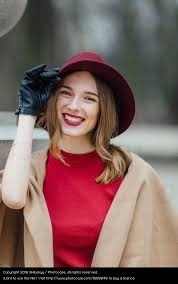

Test image number 86. True action(s): drinking



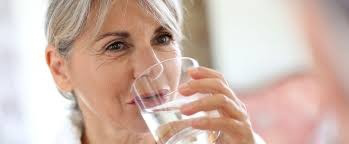

In [ ]:
rand_img("train")
rand_img("test")

## Image processing

In [ ]:
def processing(df, datatype):

    """

    Resizes dataset images and associate each
    image to its label from a Pandas dataframe

    In: Pandas Dataframe, String
    Out: Numpy array of images, List of categories

    """

    global classes

    imgs_as_arrays = []
    imgs_labels_categorized = [] # 15 indexes

    if datatype == "train":
        for index, row in df.iterrows():
            img_name = row["img_name"]
            img_path = path_files + "train/" + img_name
            temp_img = Image.open(img_path)
            imgs_as_arrays.append(np.asarray(temp_img.resize(input_size)))
            
            # Label categorization
            categs = [0 for i in range(15)]
            categs[classes[row["label"]]] = 1
            imgs_labels_categorized.append(categs)

    if datatype == "test":
        for index, row in df.iterrows():
            img_name = row["img_name"]
            img_path = path_files + "test/" + img_name
            temp_img = Image.open(img_path)
            imgs_as_arrays.append(np.asarray(temp_img.resize(input_size)))

            # Label categorization
            imgs_labels_categorized.append(row.tolist()[1:])

    return np.asarray(imgs_as_arrays), np.asarray(imgs_labels_categorized)

In [ ]:
# Processes images according to dataset type
X_train, y_train = processing(train_csv, "train")
X_test, y_test = processing(test_csv, "test")

In [ ]:
# Debug
#display(X_train[0])
#display(X_test[0])

In [ ]:
#display(y_train)
#display(y_test)

# Model configuration

In [ ]:
m = Sequential()

vgg = tf.keras.applications.VGG16(
            include_top=False,
            input_shape=input_shape,
            pooling=pooling,
            classes=15,
            weights="imagenet")

for layer in vgg.layers:
    layer.trainable = False

m.add(vgg)
m.add(Flatten())
m.add(Dense(512, activation="relu"))
m.add(Dense(15, activation="softmax"))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Compile model
m.compile(optimizer="adam", 
          loss="categorical_crossentropy",
          metrics=["categorical_accuracy"])

In [ ]:
# Short description of neural network architecture
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14,985,039
Trainable params: 270,351
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
hist = m.fit(X_train, y_train, epochs=epochs)

Epoch 1/40
394/394 [==============================] - 73s 159ms/step - loss: 1.8740 - categorical_accuracy: 0.4863
Epoch 2/40
394/394 [==============================] - 63s 159ms/step - loss: 1.1335 - categorical_accuracy: 0.6315
Epoch 3/40
394/394 [==============================] - 63s 159ms/step - loss: 0.9132 - categorical_accuracy: 0.7011
Epoch 4/40
394/394 [==============================] - 62s 158ms/step - loss: 0.7584 - categorical_accuracy: 0.7461
Epoch 5/40
394/394 [==============================] - 63s 160ms/step - loss: 0.6083 - categorical_accuracy: 0.7987
Epoch 6/40
394/394 [==============================] - 62s 158ms/step - loss: 0.4754 - categorical_accuracy: 0.8393
Epoch 7/40
394/394 [==============================] - 62s 158ms/step - loss: 0.3509 - categorical_accuracy: 0.8887
Epoch 8/40
394/394 [==============================] - 62s 158ms/step - loss: 0.2703 - categorical_accuracy: 0.9132
Epoch 9/40
394/394 [==============================] - 63s 159ms/step - loss: 0.1

In [ ]:
# Save weights for later, if necessary
#m.save_weights("vgg16weights.h5")

# Training results

In [ ]:
# Accuracy and Loss plots
fig = make_subplots(rows=1, cols=2)  
fig.add_trace(go.Scatter(y=hist.history["categorical_accuracy"], 
                         name="Accuracy",
                         line=dict(color="firebrick", width=4)),
              row=1, col=1)

fig.add_trace(go.Scatter(y=hist.history["loss"], 
                         name="Loss",
                         line=dict(color="royalblue", width=4)),
              row=1, col=2)

fig.update_xaxes(title_text="Epochs", row=1, col=1)
fig.update_xaxes(title_text="Epochs", row=1, col=2)
fig.update_yaxes(title_text="Accuracy(%)", row=1, col=1)
fig.update_yaxes(title_text="Loss(absolute)", row=1, col=2)

title = "Accuracy x Loss on training (" + str(input_size[0]) + " x " + str(input_size[1]) + ", pooling=" + pooling + ")"
fig.update_layout(title=title, font=dict(size=20))

fig.show()

# Evaluation and single-image prediction for ilustration


In [ ]:
# Function to predict

def rand_pred(model):

    """

    Makes a prediction with a random test image,
    given the trained model

    In: Keras Model
    Out: None

    """

    global actions

    # Get random test image and processes it 
    # to fit model criteria
    rand_index = randint(1, len(test_fol))
    img_path = path_files + "test/Image_" + str(rand_index) + ".jpg"
    imgt = Image.open(img_path)
    img_pred = np.asarray(imgt.resize(input_size))
    img_pred = np.expand_dims(img_pred, axis=0)

    # Make prediction
    result = model.predict(img_pred)

    # Find biggest probability (softmax value)
    pred = np.where(result==np.max(result))[1][0]
    
    # Find labels associated with image (actual names of actions)
    img_name = "Image_" + str(rand_index) + ".jpg"
    img_info = test_csv[test_csv["img_name"] == img_name]
    labels = img_info.values[0].tolist()[1:]

    # Text formatting for prediction display
    p_action  = actions[pred]
    t_actions = ""
    for i in range(15):
        if labels[i] == 1:
            t_actions += " " + actions[i]

    # Show true and predicted labels alongside image
    print("Test image number " + str(rand_index))
    print("Predicted action: " + p_action)
    print("True action(s):  " + t_actions)

    # Show image
    fig = px.imshow(imgt)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(title="Random image prediction", font=dict(size=20))
    fig.show()

In [ ]:
# predict entire test dataset for accuracy measurement
m.evaluate(X_test, y_test)

169/169 [==============================] - 27s 158ms/step - loss: 16.9315 - categorical_accuracy: 0.5331


[16.931488037109375, 0.5331481695175171]

1/1 [==============================] - 0s 17ms/step
Test image number 4809
Predicted action: laughing
True action(s):   laughing



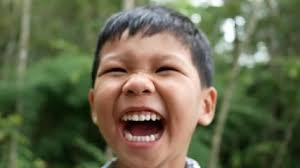

In [ ]:
rand_pred(m)